## Copy data to new directory

In [1]:
import os
import shutil
import pandas as pd
from os.path import join as opj

source_dir = r'/mnt/data/Project/DCM/BIDS/sourcedata'
output_dir = r'/mnt/data/tmp/Data2Heli'
# read data from source directory
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')

# copy meg data
data = participants_data.query('meg_neuro==1')
pid = data['Participant_ID'].to_list()
subject_list = pid
subject_list = ['sub_'+str(id).zfill(3) for id in range(64,83)]

# creat directory structure in output directory
def copy_meg_resting(sub_id):
    original_dir = r'/mnt/workdir/DCM/sourcedata'
    output_dir = '/mnt/data/tmp/Data2Heli'

    sourMegDir = opj(original_dir, sub_id, 'NeuroData','MEG')
    targMegDir = opj(output_dir, sub_id, 'MEG')

    if not os.path.exists(targMegDir):
        os.makedirs(targMegDir)

    file_list = os.listdir(sourMegDir)
    target_files = []
    for f in file_list:
        if 'rest' in f:
            target_files.append(f)
        else:
            continue

    for target_file in target_files:
        source_file_path = opj(sourMegDir,target_file)
        target_file_path = opj(targMegDir,target_file)
        if '.fif' in target_file:
            shutil.copy(source_file_path,target_file_path)
        elif '.ds' in target_file:
            shutil.copytree(source_file_path,target_file_path)

for sub in subject_list:
    copy_meg_resting(sub)

In [33]:
# copy fmri resting data and T1
def copy_mri_resting(sub_id):
    original_dir = r'/mnt/workdir/DCM/BIDS'
    output_dir = '/mnt/data/tmp/Data2Heli'

    sourMriDir = opj(original_dir, sub_id)
    targMriDir = opj(output_dir, sub_id.replace('-','_'), 'MRI')

    if not os.path.exists(targMriDir):
        os.makedirs(targMriDir)

    mri_modes = ['anat','func']

    for mode in mri_modes:
        if mode in ['anat']:
            source_file_path = opj(sourMriDir,mode)
            target_file_path = opj(targMriDir,mode)
            shutil.copytree(source_file_path,target_file_path)
        elif mode == 'func':
            file_list = os.listdir(opj(sourMriDir,'func'))
            target_files = []
            for f in file_list:
                if 'rest' in f:
                    target_files.append(f)
                    print(f)
                else:
                    continue
            for target_file in target_files:
                source_file_path = opj(sourMriDir,mode,target_file)
                target_file_path = opj(targMriDir,mode,target_file)
                if not os.path.exists(opj(targMriDir,mode)):
                    os.makedirs(opj(targMriDir,mode))
                shutil.copy(source_file_path,target_file_path)

participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')

# copy meg data
data = participants_data.query('game1_fmri==1')
subject_list = data['Participant_ID'].to_list()
subject_list = [s.replace('_','-') for s in subject_list]
subject_list.remove('sub-015')
for sub in subject_list:
    copy_mri_resting(sub)

sub-010_task-rest_run-02_bold.json
sub-010_task-rest_run-02_bold.nii.gz
sub-010_task-rest_run-01_bold.json
sub-010_task-rest_run-01_bold.nii.gz
sub-011_task-rest_run-01_bold.json
sub-011_task-rest_run-02_bold.json
sub-011_task-rest_run-01_bold.nii.gz
sub-011_task-rest_run-02_bold.nii.gz
sub-012_task-rest_run-02_bold.nii.gz
sub-012_task-rest_run-01_bold.json
sub-012_task-rest_run-02_bold.json
sub-012_task-rest_run-01_bold.nii.gz
sub-016_task-rest_run-01_bold.nii.gz
sub-016_task-rest_run-02_bold.nii.gz
sub-016_task-rest_run-02_bold.json
sub-016_task-rest_run-01_bold.json
sub-017_task-rest_run-02_bold.json
sub-017_task-rest_run-02_bold.nii.gz
sub-017_task-rest_run-01_bold.json
sub-017_task-rest_run-01_bold.nii.gz
sub-018_task-rest_run-01_bold.nii.gz
sub-018_task-rest_run-02_bold.json
sub-018_task-rest_run-01_bold.json
sub-018_task-rest_run-02_bold.nii.gz
sub-022_task-rest_run-01_bold.nii.gz
sub-022_task-rest_run-02_bold.json
sub-022_task-rest_run-01_bold.json
sub-022_task-rest_run-02_bold

In [29]:
subject_list[0].rep

['sub_010',
 'sub_011',
 'sub_012',
 'sub_015',
 'sub_016',
 'sub_017',
 'sub_018',
 'sub_022',
 'sub_023',
 'sub_024',
 'sub_025',
 'sub_027',
 'sub_029',
 'sub_031',
 'sub_032',
 'sub_033',
 'sub_036',
 'sub_037',
 'sub_043',
 'sub_046',
 'sub_047',
 'sub_048',
 'sub_049',
 'sub_050',
 'sub_053',
 'sub_055',
 'sub_056',
 'sub_059',
 'sub_060',
 'sub_061',
 'sub_062',
 'sub_063',
 'sub_064',
 'sub_065',
 'sub_067',
 'sub_068',
 'sub_069',
 'sub_070',
 'sub_071',
 'sub_072',
 'sub_073',
 'sub_074',
 'sub_075',
 'sub_076',
 'sub_077',
 'sub_078',
 'sub_079',
 'sub_080',
 'sub_082']

## copy event file to new directory

In [ ]:
import os
import shutil
from os.path import join as opj

source_dir = r'/mnt/data/Project/DCM/BIDS/derivatives/fmriprep_surfer'
output_dir = r'/mnt/data/Project/DCM/BIDS/derivatives/Events'
# read data from source directory
sub_list = ['sub-{}'.format(str(idx).zfill(3)) for idx in range(12,48)]
# creat directory structure in output directory
for i,sub in enumerate(sub_list):
    if not os.path.exists(opj(source_dir, sub, 'events')):
        print(sub, " haven't event files.")
        continue
    for event_type in ['hexonM2Long', 'hexonM2Short', 'hexonRule']:
        souEvPath = opj(source_dir, sub, 'events',event_type)
        tarSubdir = (opj(output_dir, sub))
        if not os.path.exists(tarSubdir):
            os.mkdir(tarSubdir)
        tarEvPath = opj(output_dir, sub, event_type)
        #shutil.move(souEvPath, tarEvPath)
        
        try:
            shutil.move(souEvPath, tarEvPath)
        except:
            if os.path.exists(tarEvPath):
                print("Error: {} file can't be moved!".format(sub))
            else:
                print("{} haven't {}".format(sub,event_type))

    print("————————{} already been copyed. still have {} subject ————————".format(sub,len(sub_list)-i-1))
    os.rmdir(opj(source_dir, sub, 'events'))
    

## Convert formate of event files to fsl format

In [ ]:
import os
import numpy as np
import pandas as pd 
from os.path import join as opj


def ev2fsl(ev_file,save_dir,prefix):
    ev_info = pd.read_csv(ev_file, sep='\t')
    for group in ev_info.groupby('trial_type'):
        condition = group[0]
        onsets = np.array(group[1].onset.tolist())
        durations = np.array(group[1].duration.tolist())
        if condition in ['sin','cos']:
            amplitudes = np.array(group[1].modulation.tolist())
        else:
            amplitudes = np.array([1]*len(onsets))
        fsl_ev = np.array([onsets,durations,amplitudes]).T.astype('float32')
        #os.makedirs(save_dir)
        np.savetxt(opj(save_dir,'{}_{}.txt'.format(prefix,condition)),fsl_ev,fmt='%.02f',delimiter='\t') # dilimiter: Tab

        
        
def game1tofsl(ev_dir,save_dir,ev_template):
    for i in range(1,7):
        ev_file = opj(ev_dir,ev_template.format(i))
        ev2fsl(ev_file,save_dir,'run{}'.format(i))


        
ev_dir=  r'/mnt/data/Project/DCM/BIDS/derivatives/Events/sub-046/hexonM2Short/6fold'
save_dir= r'/mnt/data/Project/DCM/BIDS/derivatives/Events/sub-046/fsl/hexonM2Short/6fold'
os.makedirs(save_dir)
ev_template= r'sub-046_task-game1_run-{}_events.tsv'

game1tofsl(ev_dir,save_dir,ev_template)

## sum mask

In [ ]:
from nilearn.image import load_img,resample_to_img,math_img,new_img_like

mask1 = load_img(r'/mnt/data/Template/EC_prob_roi.nii.gz')
mask2 = load_img(r'/mnt/data/Template/EC_anatomy_roi.nii.gz')
tar_img = load_img(r'/mnt/data/Project/DCM/BIDS/derivatives/fmriprep_surfer/sub-010/anat/sub-010_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')
mask1_tar = resample_to_img(mask1,tar_img,interpolation='nearest')
mask2_tar = resample_to_img(mask2,tar_img,interpolation='nearest')

mask1_data = mask1_tar.get_fdata()
mask2_data = mask2_tar.get_fdata()
mask_sum = mask1_data + mask2_data[:,:,:,0]
mask_sum[mask_sum!=0]=1
mask_sum_img = new_img_like(mask1_tar,mask_sum)
mask_sum_img.to_filename(r'/mnt/data/Template/EC_roi_sum.nii.gz')

## extract EC mask from probabilistic atlas

In [ ]:
import numpy as np

from nilearn.image import load_img,new_img_like


def extract_sp_val(promap_data,sp_val):
    '''extract special value map:
    Parameters:
    promap    :  3d array,1-3 repersents xyz coorodinates
    sp_val :  special value will be extracted and binaryzed.'''
    coordinate_shape = promap_data.shape
    extract_map = np.zeros(coordinate_shape)
    for i in sp_val:
        extract_map[promap_data[:, :, :] == i] = 1
    return extract_map


atlas_path = r'/mnt/workdir/DCM/docs/Reference/EC_ROI/Juelich-maxprob-thr50-2mm.nii.gz'
atlas = load_img(atlas_path)
prob_map = atlas.get_fdata()

ec_mask = extract_sp_val(prob_map,[19,20])
ec = new_img_like(atlas,ec_mask,affine=atlas.affine)
ec.to_filename(r'/mnt/workdir/DCM/docs/Reference/EC_ROI/EC-thr50-2mm.nii.gz')

In [ ]:
from nilearn import plotting
surf_mesh = r'/mnt/workdir/DCM/BIDS/derivatives/fmriprep_surfer/sourcedata/freesurfer/fsaverage/surf/lh.white'
surf_map = r'/mnt/workdir/DCM/docs/Reference/EC_ROI/surfer/Juelich_maxprob_thr0_2mm/1395.L.func.gii'

plt_surf = plotting.view_surf(surf_mesh,surf_map,symmetric_cmap=False)
plt_surf.open_in_browser()

In [ ]:
import nibabel
import os
func_dir = r'/mnt/workdir/DCM/BIDS/derivatives/fmriprep_volume/sub-010/func'
func_name = 'sub-010_task-game1_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
func_path = os.path.join(func_dir,func_name)
func_img = nibabel.load(func_path)
func_img.affine

In [ ]:
import nibabel
import os
func_dir = r'/mnt/workdir/DCM/BIDS/derivatives/fmriprep_volume/sub-010/func'
func_name = 'sub-010_task-game1_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'

func_path = os.path.join(func_dir,func_name)
func_path = r'/mnt/data/Template/res-02_brainMask.nii'
func_img = nibabel.load(func_path)
func_img.get_fdata().max()

In [ ]:
import nibabel
import os
import numpy as np
#func_dir = r'/mnt/workdir/DCM/BIDS/sub-010/func'
#func_name = r'sub-010_task-game1_run-01_bold.nii.gz'
#func_path = os.path.join(func_dir,func_name)
func_path = r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii'
func_img = nibabel.load(func_path)
func_img.get_fdata().min()

# Show the MRI slices of the result

In [ ]:
import pandas as pd
import seaborn as sns

trainset1_phi = pd.read_csv(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/Phi/trainset1_estPhi.csv').query('ifold=="6fold"')
trainset2_phi = pd.read_csv(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/Phi/trainset2_estPhi.csv').query('ifold=="6fold"')

trainset1_phi['session'] = 'sess1'
trainset2_phi['session'] = 'sess2'

phi = pd.concat([trainset1_phi,trainset2_phi])
phi['phi_diff'] = phi['ec_phi'] - phi['vmpfc_phi']
sns.scatterplot(data=phi,x='session',y='phi_diff')

phi_diff_sess1 = abs(phi.query("session=='sess1'")['phi_diff']).to_list()
phi_diff_sess2 = abs(phi.query("session=='sess2'")['phi_diff']).to_list()
from scipy.stats import ttest_ind

t,p = ttest_ind(phi_diff_sess1,phi_diff_sess2)
print('p:',round(p,3))

# add covariate:Age

In [ ]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Age/2ndLevel/_contrast_id_ZF_0004/spmT_0002.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=2.3,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-4],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[0],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-18],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

# add covariate:2D acc

In [ ]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Acc/2ndLevel/_contrast_id_ZF_0004/spmT_0002.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=2.3,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[6],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-12],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

# add covariates: age and acc

### Age

In [ ]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Age_plus_Acc/2ndLevel/_contrast_id_ZF_0004/spmT_0002.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

cut_coords = [-4,2,-18]

#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=2.3,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-4],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[0],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-18],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

### Acc

In [ ]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Age_plus_Acc/2ndLevel/_contrast_id_ZF_0004/spmT_0003.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[6],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-12],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

In [ ]:
import numpy as np
from nilearn.plotting import plot_stat_map,plot_roi
from nilearn.image import load_img,math_img,new_img_like
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/'
                    r'hp/2ndLevel/_contrast_id_ZF_0004/spmT_0001.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

vmpfc_mask = load_img(r'/mnt/workdir/DCM/docs/Reference/Park_Grid_Coding/osfstorage-archive/data/Analysis_ROI_nii/mPFC_Grid_roi.nii')

stat_data = stat_map.get_fdata()
stat_data[stat_data<=0]  = np.float64('NaN')
stat_map = new_img_like(stat_map, stat_data)

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-4],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[3],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

# EC

In [ ]:
import numpy as np
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img,new_img_like
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/test_set/EC/group/hp/mean_spmT_align_EC_Phi.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')


stat_data = stat_map.get_fdata()
stat_data[stat_data<=0]  = np.float64('NaN')
stat_map = new_img_like(stat_map, stat_data)

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-19],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[31],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)
% md
# vmpfc

In [ ]:
import numpy as np
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img,new_img_like
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/test_set/vmpfc/group/hp/mean_spmT_align_vmpfc_Phi.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')


stat_data = stat_map.get_fdata()
stat_data[stat_data<=0]  = np.float64('NaN')
stat_map = new_img_like(stat_map, stat_data)

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[4],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-33],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[3],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-19],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

## copy data for he li

In [ ]:
import shutil

original_dir = r''


In [ ]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,5,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/adult/2ndLevel/_contrast_id_ZF_0004/spmT_0001.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')
stat_map = math_img("np.where(img<0,0,img)",img=stat_map)

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=1.69,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[6],threshold=1.69,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[24],threshold=1.69,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=1.69,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[0],threshold=1.69,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[3],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-24],threshold=1.69,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[4],colorbar=True)

In [ ]:
from nilearn.reporting import get_clusters_table

stat_map = r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexonM2short/specificTo6/training_set/trainsetall/group/covariates/2ndLevel/_contrast_id_ZF_0004/' \
           r'spmT_0003.nii'
df = get_clusters_table(stat_map,2.8,20)

In [12]:
import nibabel
import os
func_dir = r'/mnt/workdir/DCM/BIDS/derivatives/fmriprep_volume/sub-010/func'
func_name = 'sub-010_task-game1_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
func_path = os.path.join(func_dir,func_name)
func_img = nibabel.load(func_path)
func_img.affine

array([[   3. ,    0. ,    0. ,  -96.5],
       [   0. ,    3. ,    0. , -132.5],
       [   0. ,    0. ,    3. ,  -78.5],
       [   0. ,    0. ,    0. ,    1. ]])

In [37]:
import nibabel
import os
func_dir = r'/mnt/workdir/DCM/BIDS/derivatives/fmriprep_volume/sub-010/func'
func_name = 'sub-010_task-game1_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'

func_path = os.path.join(func_dir,func_name)
func_path = r'/mnt/data/Template/res-02_brainMask.nii'
func_img = nibabel.load(func_path)
func_img.get_fdata().max()

1.0

In [38]:
import nibabel
import os
import numpy as np
#func_dir = r'/mnt/workdir/DCM/BIDS/sub-010/func'
#func_name = r'sub-010_task-game1_run-01_bold.nii.gz'
#func_path = os.path.join(func_dir,func_name)
func_path = r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii'
func_img = nibabel.load(func_path)
func_img.get_fdata().min()

0.0

# Show the MRI slices of the result

p: 0.108


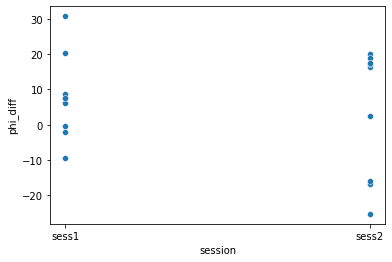

In [100]:
import pandas as pd
import seaborn as sns

trainset1_phi = pd.read_csv(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/Phi/trainset1_estPhi.csv').query('ifold=="6fold"')
trainset2_phi = pd.read_csv(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/Phi/trainset2_estPhi.csv').query('ifold=="6fold"')

trainset1_phi['session'] = 'sess1'
trainset2_phi['session'] = 'sess2'

phi = pd.concat([trainset1_phi,trainset2_phi])
phi['phi_diff'] = phi['ec_phi'] - phi['vmpfc_phi']
sns.scatterplot(data=phi,x='session',y='phi_diff')

phi_diff_sess1 = abs(phi.query("session=='sess1'")['phi_diff']).to_list()
phi_diff_sess2 = abs(phi.query("session=='sess2'")['phi_diff']).to_list()
from scipy.stats import ttest_ind

t,p = ttest_ind(phi_diff_sess1,phi_diff_sess2)
print('p:',round(p,3))

# add covariate:Age

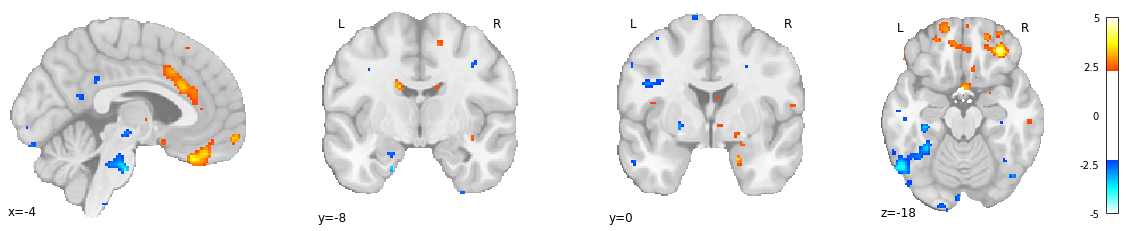

In [29]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Age/2ndLevel/_contrast_id_ZF_0004/spmT_0002.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=2.3,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-4],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[0],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-18],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

# add covariate:2D acc

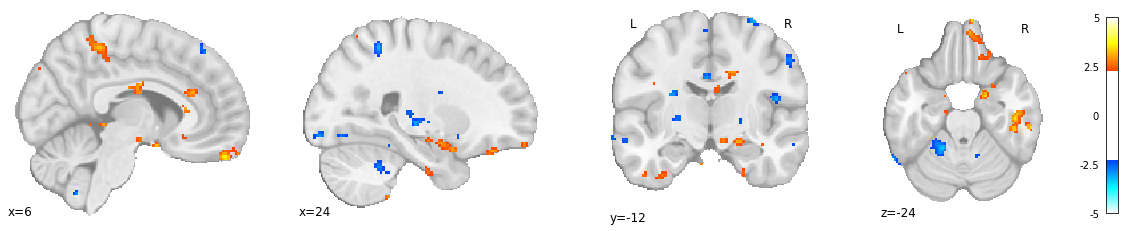

In [30]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Acc/2ndLevel/_contrast_id_ZF_0004/spmT_0002.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=2.3,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[6],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-12],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

# add covariates: age and acc

### Age

ValueError: File not found: '/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/Age_plus_Acc/2ndLevel/_contrast_id_ZF_0004/spmT_0002.nii'

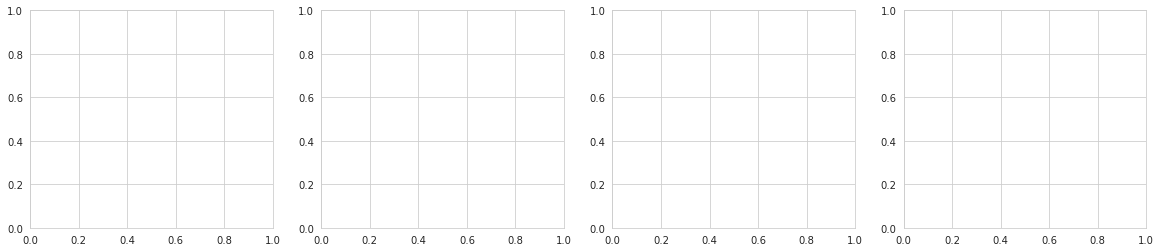

In [21]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Age_plus_Acc/2ndLevel/_contrast_id_ZF_0004/spmT_0002.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

cut_coords = [-4,2,-18]

#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=2.3,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-4],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[0],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-18],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

### Acc

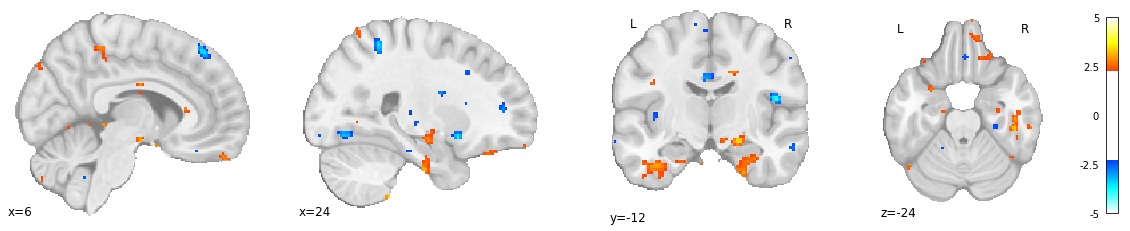

In [32]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/all/'
                    r'Age_plus_Acc/2ndLevel/_contrast_id_ZF_0004/spmT_0003.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[6],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-12],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-24],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

/home/dell/.local/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


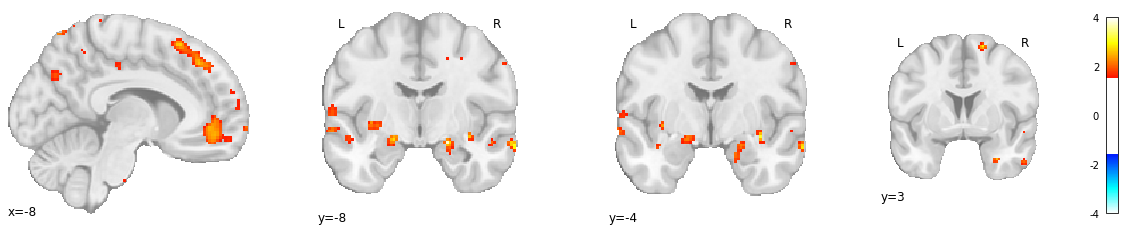

In [102]:
import numpy as np
from nilearn.plotting import plot_stat_map,plot_roi
from nilearn.image import load_img,math_img,new_img_like
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/'
                    r'hp/2ndLevel/_contrast_id_ZF_0004/spmT_0001.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')

vmpfc_mask = load_img(r'/mnt/workdir/DCM/docs/Reference/Park_Grid_Coding/osfstorage-archive/data/Analysis_ROI_nii/mPFC_Grid_roi.nii')

stat_data = stat_map.get_fdata()
stat_data[stat_data<=0]  = np.float64('NaN')
stat_map = new_img_like(stat_map, stat_data)

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-4],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[3],threshold=1.6,vmax=4,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

# EC

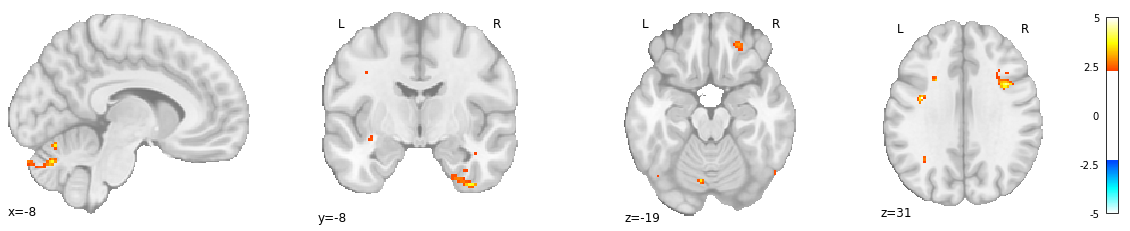

In [87]:
import numpy as np
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img,new_img_like
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/test_set/EC/group/hp/mean_spmT_align_EC_Phi.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')


stat_data = stat_map.get_fdata()
stat_data[stat_data<=0]  = np.float64('NaN')
stat_map = new_img_like(stat_map, stat_data)

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-19],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[31],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)
% md
# vmpfc

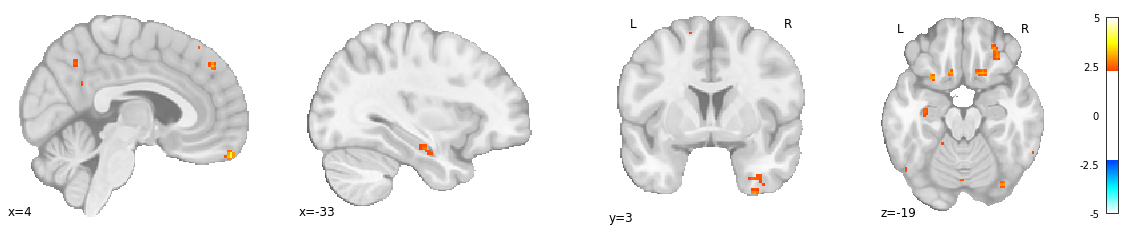

In [86]:
import numpy as np
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img,new_img_like
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,4,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/test_set/vmpfc/group/hp/mean_spmT_align_vmpfc_Phi.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')


stat_data = stat_map.get_fdata()
stat_data[stat_data<=0]  = np.float64('NaN')
stat_map = new_img_like(stat_map, stat_data)

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[4],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-33],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[3],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-19],threshold=2.3,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[3],colorbar=True)

## copy data for he li

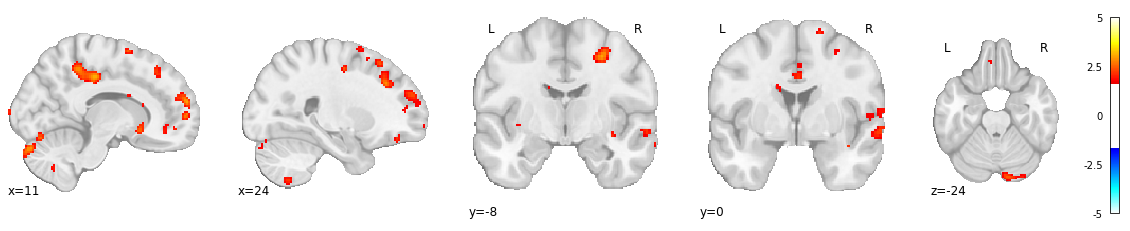

In [20]:
from nilearn.plotting import plot_stat_map,plot_glass_brain
from nilearn.image import load_img,math_img
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,5,figsize=[20,4])
stat_map = load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/hexagon/specificTo6/training_set/trainsetall/group/adult/2ndLevel/_contrast_id_ZF_0004/spmT_0001.nii')

bg_img = load_img(r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_desc-brain_T1w.nii.gz')
stat_map = math_img("np.where(img<0,0,img)",img=stat_map)

plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[11],threshold=1.69,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[0],colorbar=False)
#plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[6],threshold=1.69,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
#              axes=ax[0],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[24],threshold=1.69,vmax=5,symmetric_cbar=1,display_mode='x',black_bg=0,figure=fig,
              axes=ax[1],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-8],threshold=1.69,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[2],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[0],threshold=1.69,vmax=5,symmetric_cbar=1,display_mode='y',black_bg=0,figure=fig,
              axes=ax[3],colorbar=False)
plot_stat_map(stat_map_img=stat_map,bg_img=bg_img,cut_coords=[-24],threshold=1.69,vmax=5,symmetric_cbar=1,display_mode='z',black_bg=0,figure=fig,
              axes=ax[4],colorbar=True)

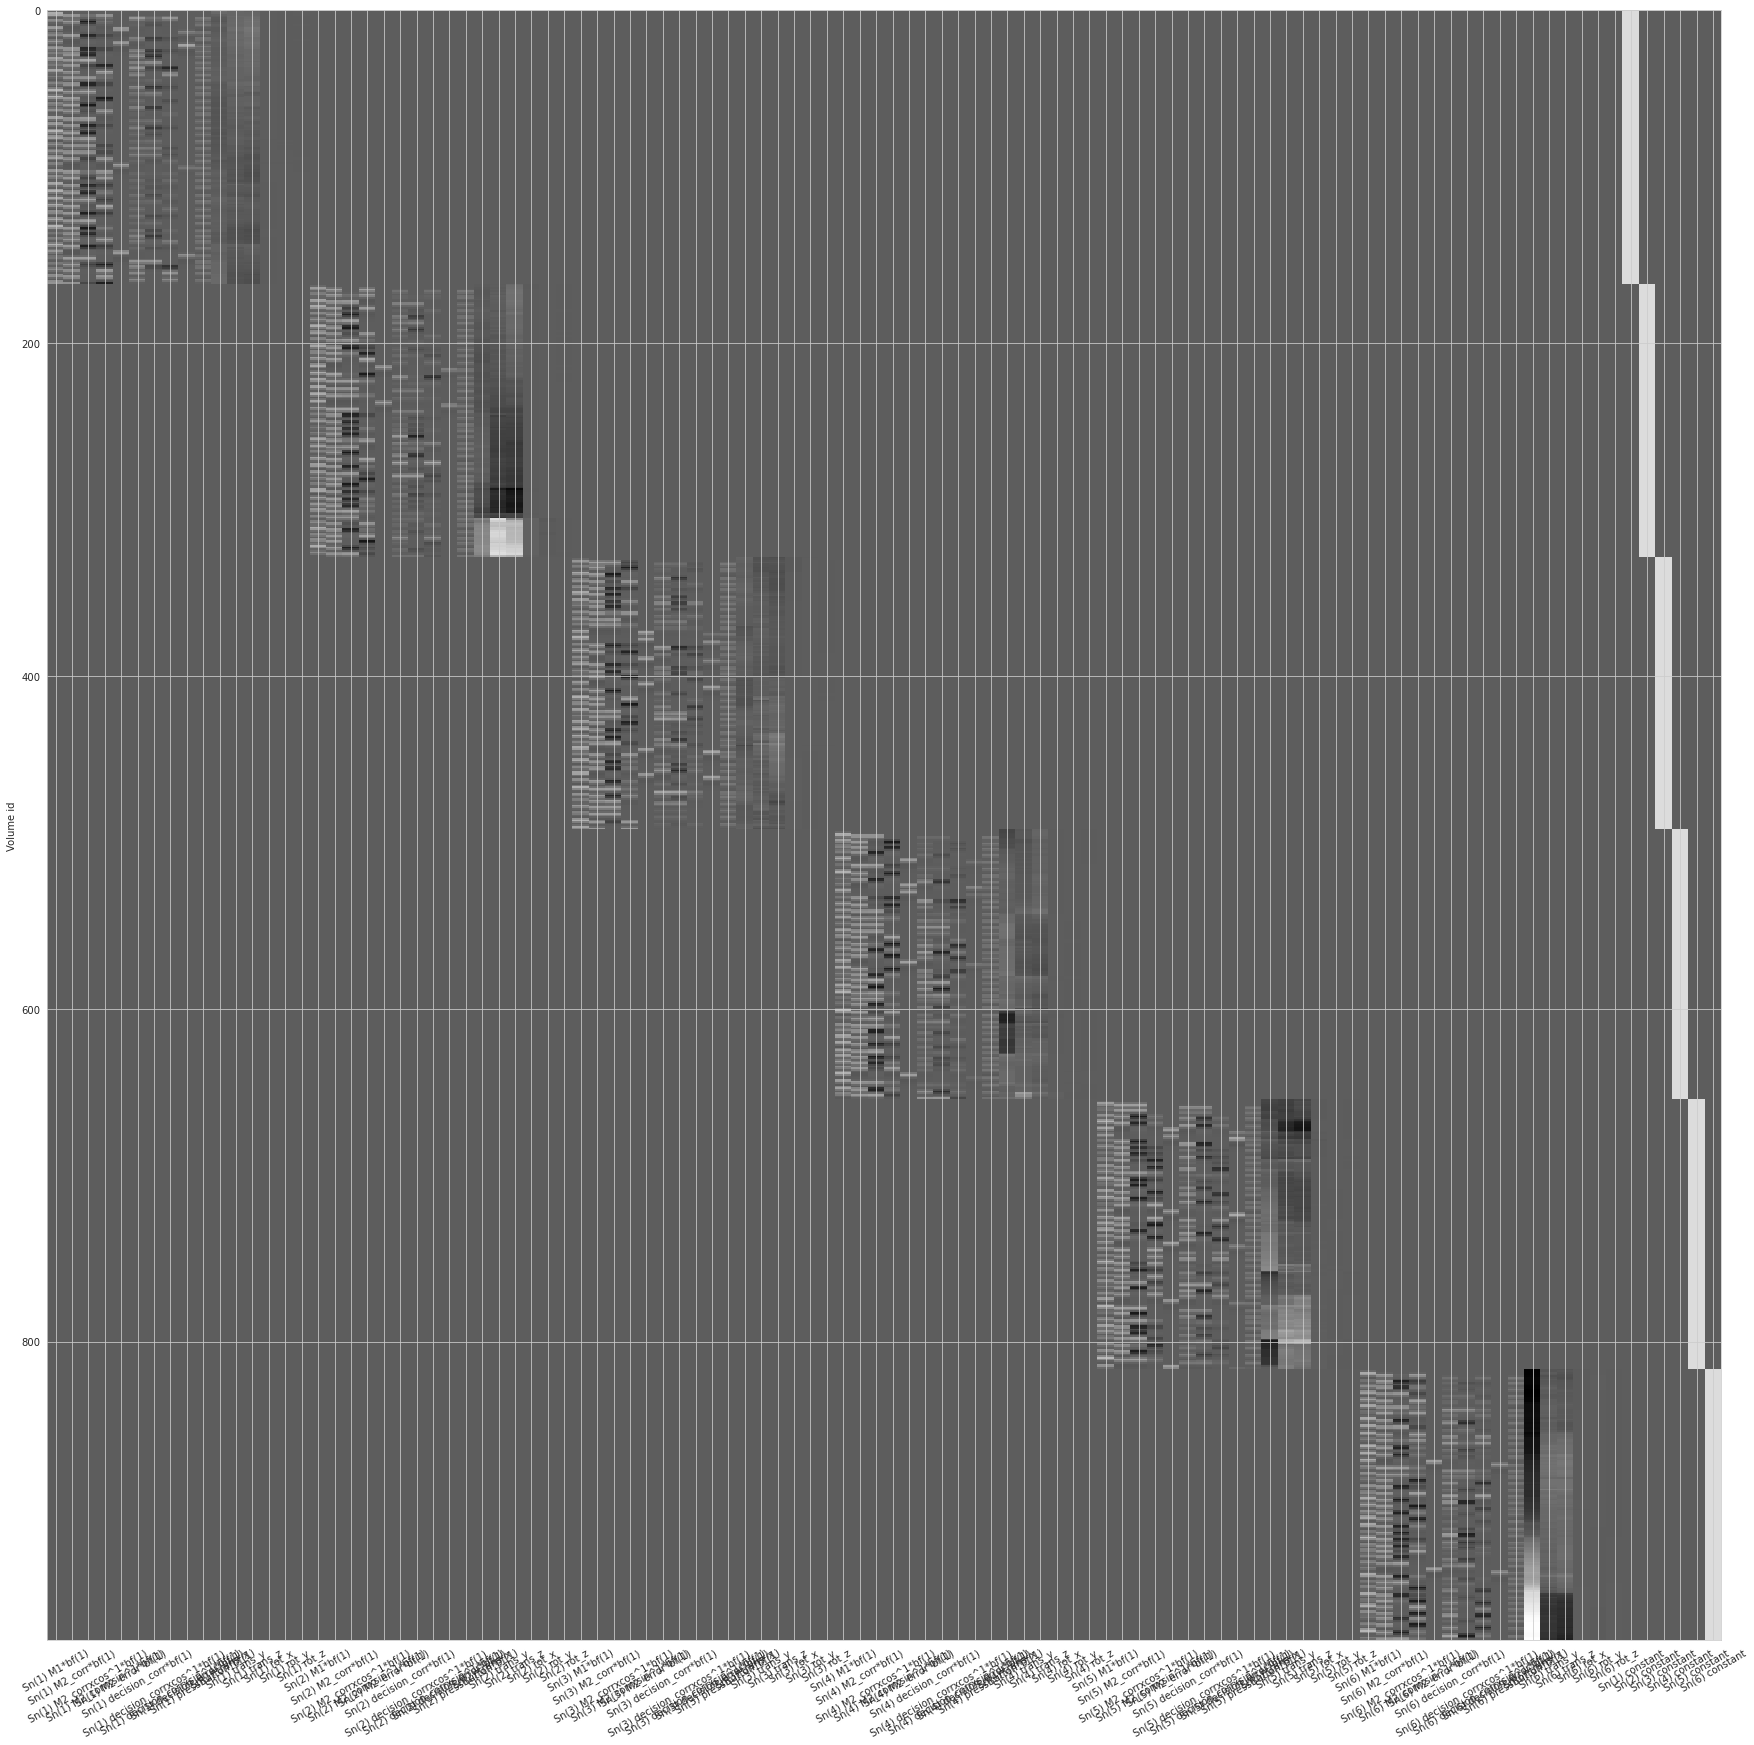

'/mnt/workdir/DCM/code/misc/spm_mat.png'

In [50]:
from scipy.io import loadmat
def plotDesignMatrix(matFile):
    import numpy as np
    import seaborn as sns
    from matplotlib import pyplot as plt
    from scipy.io import loadmat
    from os.path import join as opj
    import os

    fig_filename_full = opj(os.getcwd(), 'spm_mat.png')      # create filename

    spmmat = loadmat(matFile,                           # Using scipy's loadmat function we can access SPM.mat
struct_as_record=False)

    # normalize data
    designMatrix = spmmat['SPM'][0][0].xX[0][0].X[:,:]
    names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]][:]

    normed_design = designMatrix / np.abs(designMatrix).max(axis=0)

    # save figure
    fig_f, ax_f = plt.subplots(figsize=(30, 30))
    plt.imshow(designMatrix, aspect='auto', cmap='gray', interpolation='none')
    ax_f.set_ylabel('Volume id')
    ax_f.set_xticks(np.arange(len(names)))
    ax_f.set_xticklabels(names, rotation=30)
    plt.show()
    #fig_f.savefig(r'/mnt/workdir/DCM/tmp/design_matrix.png')
    plt.close(fig_f)

    return fig_filename_full
#spm_file = r'/home/dell/Documents/File/worklog/2022.10/Find the Bug/fmriprep_volume_with_bug/_subj_id_099/level1conest/SPM.mat'
spm_file = r'/home/dell/Documents/File/worklog/2022.10/Find the Bug/fmriprep_volume_ica_without_bug/sub-099/SPM.mat'
plotDesignMatrix(spm_file)

In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import loadmat
from os.path import join as opj
import os

spm_file = r'/mnt/workdir/DCM/BIDS/derivatives/SPM/sub-099/SPM.mat'

spmmat = loadmat(spm_file,struct_as_record=False)
designMatrix = spmmat['SPM'][0][0].xX[0][0].nKX
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]

design_matrix = pd.DataFrame(designMatrix,columns=names)
design_matrix

,Sn(1) M1*bf(1),Sn(1) M2_corr*bf(1),Sn(1) M2_corrxsin^1*bf(1),Sn(1) M2_corrxcos^1*bf(1),Sn(1) M2_error*bf(1),Sn(1) decision_corr*bf(1),Sn(1) decision_corrxsin^1*bf(1),Sn(1) decision_corrxcos^1*bf(1),Sn(1) decision_error*bf(1),Sn(1) pressButton*bf(1),Sn(1) trans_x,Sn(1) trans_y,Sn(1) trans_z,Sn(1) rot_x,Sn(1) rot_y,Sn(1) rot_z,Sn(1) constant
0,-0.039194,0.010605,-0.240763,-0.148484,0.013541,0.014235,-0.040415,-0.062842,0.017877,0.061010,0.030109,-0.029191,-0.101882,-0.061772,-0.017446,0.059752,1.000000
1,0.050381,-0.022011,-0.271397,-0.146979,0.013676,0.013659,-0.040519,-0.062519,0.017923,0.059457,0.025147,0.002049,-0.028546,-0.044748,-0.023663,0.044978,0.905176
2,0.793316,0.210876,-0.033731,-0.144009,0.013945,0.004372,-0.047975,-0.061878,0.018014,0.040383,-0.030225,-0.028287,-0.029121,-0.026990,0.018413,0.009125,0.900335
3,0.448341,0.919023,0.682573,-0.139881,0.014343,0.062672,0.005126,-0.060921,0.018150,0.101071,-0.050101,-0.010939,0.000029,-0.015030,0.023715,-0.033356,0.899990
4,0.001407,0.407772,0.178869,-0.139564,0.014861,0.321777,0.237357,-0.059668,0.018330,1.000000,-0.084554,-0.028339,0.008701,-0.008685,0.028769,-0.024414,0.900134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,0.008400,0.353176,0.031942,-0.492861,0.017490,0.175863,-0.065102,-0.273610,0.017478,0.755226,-0.205755,-0.195502,-0.166963,-0.077254,0.170413,0.046000,0.900134
160,0.141000,-0.078006,0.176689,-0.165228,0.017322,0.093064,-0.041278,-0.178159,0.017181,0.516216,-0.175038,-0.156124,-0.219658,-0.099052,0.177811,0.180911,0.899990
161,0.545086,0.478953,-0.038436,0.552843,0.017193,-0.022173,-0.008415,-0.061992,0.016952,0.038251,-0.274975,-0.110546,-0.183231,-0.179178,0.251943,0.080700,0.900335
162,0.171228,0.654064,-0.102939,0.710656,0.017105,-0.029734,-0.008566,0.003351,0.016797,-0.128140,-0.309560,-0.088724,-0.073818,-0.185842,0.199241,0.045967,0.905176


In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import loadmat
from os.path import join as opj
import os

spm_file = r'/mnt/workdir/DCM/BIDS/derivatives/Nipype/working_dir/game1/separate_hexagon/Setall/6fold/work_1st/_subj_id_099/level1conest/SPM.mat'

spmmat = loadmat(spm_file,struct_as_record=False)
designMatrix = spmmat['SPM'][0][0].xX[0][0].nKX
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]

design_matrix = pd.DataFrame(designMatrix,columns=names)
design_matrix

,Sn(1) M1*bf(1),Sn(1) M2_corr*bf(1),Sn(1) M2_corrxcos^1*bf(1),Sn(1) M2_corrxsin^1*bf(1),Sn(1) M2_error*bf(1),Sn(1) decision_corr*bf(1),Sn(1) decision_corrxcos^1*bf(1),Sn(1) decision_corrxsin^1*bf(1),Sn(1) decision_error*bf(1),Sn(1) pressButton*bf(1),...,Sn(6) trans_z,Sn(6) rot_x,Sn(6) rot_y,Sn(6) rot_z,Sn(1) constant,Sn(2) constant,Sn(3) constant,Sn(4) constant,Sn(5) constant,Sn(6) constant
0,-0.326802,0.107944,0.043398,0.074999,-0.063879,0.222740,0.064737,0.242119,0.008293,0.056759,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000
1,-0.511795,-0.043375,-0.016821,-0.063285,-0.025578,0.208976,0.063202,0.208425,-0.000202,0.072232,...,0.000000,0.000000,0.000000,0.000000,-0.359744,0.0,0.0,0.0,0.0,0.000000
2,0.776961,-0.446006,-0.192398,-0.431195,0.054217,-0.047105,-0.013937,-0.071979,-0.010537,0.022363,...,0.000000,0.000000,0.000000,0.000000,-0.488301,0.0,0.0,0.0,0.0,0.000000
3,0.511139,0.545762,0.125678,0.498070,0.070539,-0.569573,-0.200790,-0.558964,-0.004173,-0.138482,...,0.000000,0.000000,0.000000,0.000000,-0.135594,0.0,0.0,0.0,0.0,0.000000
4,-0.494555,0.306090,0.081635,0.284320,-0.010707,-0.312590,-0.102145,-0.293831,0.014713,-0.488164,...,0.000000,0.000000,0.000000,0.000000,0.182452,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.304739,-0.037406,0.106065,-0.058807,0.000000,0.0,0.0,0.0,0.0,0.951329
976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.338036,-0.141523,0.207760,-0.216570,0.000000,0.0,0.0,0.0,0.0,0.916244
977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.439387,-0.318329,0.372726,-0.395662,0.000000,0.0,0.0,0.0,0.0,0.861675
978,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.735504,-0.621647,0.659110,-0.663967,0.000000,0.0,0.0,0.0,0.0,0.776918


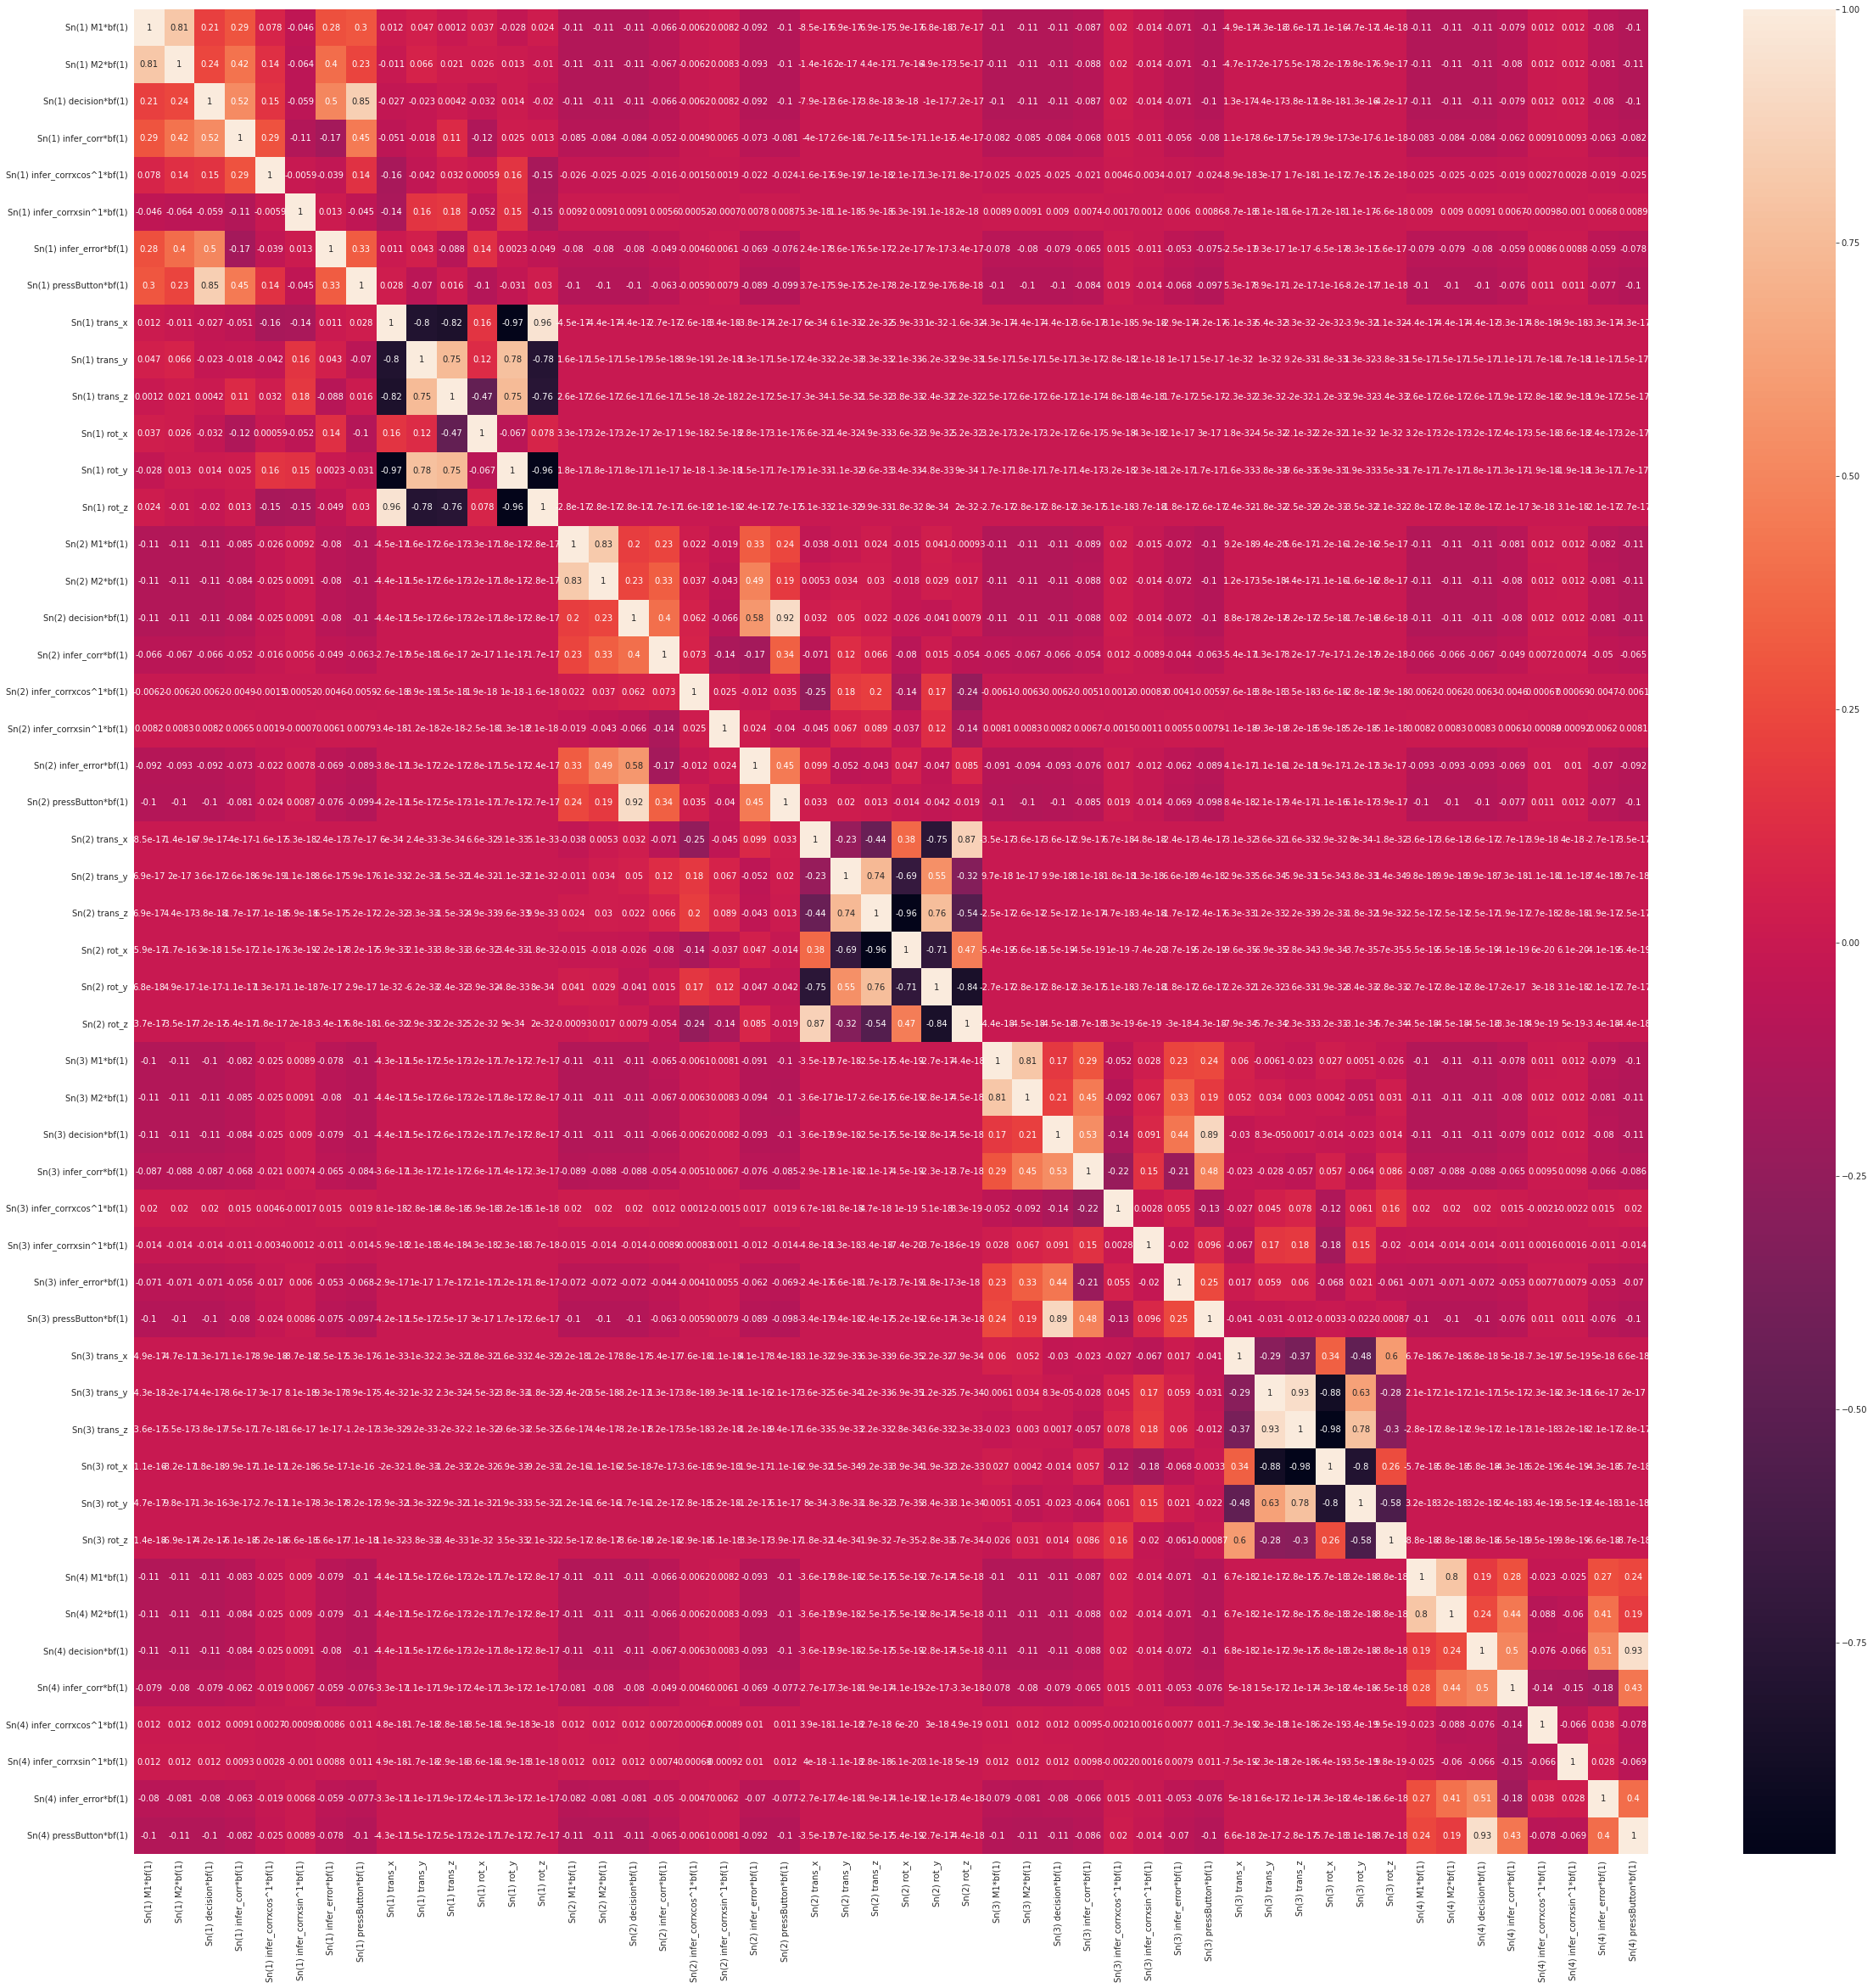

In [2]:
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
# Using scipy's loadmat function we can access SPM.mat
spmmat = loadmat('/mnt/workdir/DCM/BIDS/derivatives/Nipype/working_dir/game1/whole_hexagon_correct_trials/Setall/6fold/work_1st/_subj_id_194/level1conest/SPM.mat',
                 struct_as_record=False)

designMatrix = spmmat['SPM'][0][0].xX[0][0].X[:,:50]
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]][:50]

fix,ax = plt.subplots(figsize=(40,40))
designMatrix_df = pd.DataFrame(designMatrix,columns=names)
sns.heatmap(designMatrix_df.corr(),annot=True)
plt.show()